In [17]:
# cell 0.0: foundations: helpers (no installs, no heavy imports)
from __future__ import annotations

import os, sys, json, random, re, unicodedata, datetime, textwrap, math, subprocess
from dataclasses import dataclass, asdict
from pathlib import Path
from typing import List, Tuple, Dict, Any, Optional

def _pip(*args: str) -> None:
    subprocess.check_call([sys.executable, "-m", "pip", *args])

def try_import(name: str, import_name: Optional[str] = None):
    try:
        return __import__(import_name or name)
    except Exception:
        return None

def ensure_packaging():
    try:
        from packaging.version import Version  # noqa: F401
        from packaging.specifiers import SpecifierSet  # noqa: F401
    except Exception:
        _pip("install", "-q", "--no-cache-dir", "packaging")

def versions_dict(pkgs=("numpy","pandas","matplotlib","scipy","sklearn")) -> Dict[str, Optional[str]]:
    out = {}
    for p in pkgs:
        mod = try_import(p if p!="sklearn" else "sklearn")
        out[p] = getattr(mod, "__version__", None) if mod else None
    return out

print(json.dumps({"cell_id":"0.0 foundations: helpers","status":"ready"}, indent=2))


{
  "cell_id": "0.0 foundations: helpers",
  "status": "ready"
}


In [18]:
# cell 0.1: foundations: minimal installs (only-if-missing; never upgrade)
try:
    installed = {}
    order = ["numpy", "scipy", "scikit-learn", "pandas", "matplotlib"]
    specs = {
        "numpy": ">=2.0,<3",
        "pandas": "==2.2.2",
        "matplotlib": ">=3.8,<3.9",
        "scipy": ">=1.13,<2.0",
        "scikit-learn": ">=1.6,<1.7",
    }
    for pip_name in order:
        import_name = "sklearn" if pip_name == "scikit-learn" else pip_name
        if try_import(import_name) is None:
            _pip("install", "-q", "--no-cache-dir", "--only-binary=:all:", f"{pip_name}{specs[pip_name]}")
            installed[pip_name] = specs[pip_name]
    print(json.dumps({
        "cell_id":"0.1 foundations: installs (only-if-missing)",
        "status":"pass","installed_if_missing": installed,"versions": versions_dict()
    }, indent=2))
except Exception as e:
    print(json.dumps({"cell_id":"0.1 foundations: installs (only-if-missing)",
                      "status":"fail","error":f"{type(e).__name__}: {e}"} , indent=2))
    raise


{
  "cell_id": "0.1 foundations: installs (only-if-missing)",
  "status": "pass",
  "installed_if_missing": {},
  "versions": {
    "numpy": "2.0.2",
    "pandas": "2.2.2",
    "matplotlib": "3.10.0",
    "scipy": "1.16.1",
    "sklearn": "1.6.1"
  }
}


In [19]:
# cell 0.2: foundations: imports, determinism, version capture (CPU-only)

# stdlib (import locally so this cell is idempotent)
import os, sys, json, random

# Cap threads BEFORE importing numeric libs (repro & predictable perf)
threads = os.environ.get("LSA_THREADS", "1")
for _v in ("OPENBLAS_NUM_THREADS","MKL_NUM_THREADS","NUMEXPR_NUM_THREADS","OMP_NUM_THREADS"):
    os.environ[_v] = threads

# heavy stack (single imports cell)
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import scipy
import sklearn

# Allow thread override; default to 1 for reproducibility on CPU
threads = os.environ.get("LSA_THREADS", "1")
for _v in ("OPENBLAS_NUM_THREADS","MKL_NUM_THREADS","NUMEXPR_NUM_THREADS","OMP_NUM_THREADS"):
    os.environ[_v] = threads

SEED = int(os.environ.get("LSA_SEED","12345"))
os.environ["PYTHONHASHSEED"] = str(SEED)  # note: only affects new processes’ hash order
random.seed(SEED); np.random.seed(SEED)

# Optional strict hash guard (off by default)
if os.environ.get("LSA_HASH_GUARD","0") == "1":
    import builtins
    _orig_hash = builtins.hash
    def _det_hash_guard(x):
        raise RuntimeError("Avoid builtins.hash() for logic; nondeterministic across runs.")
    builtins.hash = _det_hash_guard

# Plot defaults (matplotlib per your preference)
plt.rcParams.update({"figure.figsize": (8,3.5), "axes.grid": True, "grid.alpha": 0.25, "figure.dpi": 110})

VERSIONS = {
    "python": sys.version.split()[0],
    "numpy": np.__version__,
    "pandas": pd.__version__,
    "matplotlib": matplotlib.__version__,
    "scipy": scipy.__version__,
    "scikit_learn": sklearn.__version__,
}
print(json.dumps({"cell_id":"0.2 foundations: imports+determinism","status":"pass","seed":SEED,"threads":threads,"versions":VERSIONS}, indent=2))


{
  "cell_id": "0.2 foundations: imports+determinism",
  "status": "pass",
  "seed": 12345,
  "threads": "1",
  "versions": {
    "python": "3.12.11",
    "numpy": "2.0.2",
    "pandas": "2.2.2",
    "matplotlib": "3.10.0",
    "scipy": "1.16.1",
    "scikit_learn": "1.6.1"
  }
}


In [20]:
# cell 0.3: foundations: configuration & directories (portable)
BASE_DIR = Path(os.environ.get("LSA_BASE_DIR","/content"))

@dataclass
class LSAPaths:
    input_dir: Path = BASE_DIR / "input_docs"
    out_dir: Path = BASE_DIR / "lsa_outputs"
    models_dir: Path = BASE_DIR / "models"

@dataclass
class LSAConfig:
    language: str = "en"
    window_sentences: int = 4
    window_stride: int = 2
    percentile_minor: float = 0.60
    percentile_unchanged: float = 0.85
    new_floor: float = 0.20
    new_floor_tfidf: float = 0.15

paths = LSAPaths(); cfg = LSAConfig()
for p in (paths.input_dir, paths.out_dir, paths.models_dir):
    p.mkdir(parents=True, exist_ok=True)

print(json.dumps({
    "cell_id":"0.3 foundations: config+dirs",
    "status":"pass",
    "base_dir": str(BASE_DIR),
    "dirs": { "input": str(paths.input_dir), "out": str(paths.out_dir), "models": str(paths.models_dir) }
}, indent=2))


{
  "cell_id": "0.3 foundations: config+dirs",
  "status": "pass",
  "base_dir": "/content",
  "dirs": {
    "input": "/content/input_docs",
    "out": "/content/lsa_outputs",
    "models": "/content/models"
  }
}


In [21]:
# cell 0.4: foundations: status logging & self-report
MODULE_STATUS: Dict[str, Dict[str, Any]] = {}

def report_status(module: str, ok: bool, note: str = "", extra: Optional[Dict[str,Any]] = None):
    MODULE_STATUS[module] = {
        "ok": bool(ok),
        "note": note,
        "extra": extra or {},
        "ts": datetime.datetime.utcnow().isoformat() + "Z",
    }
    print(json.dumps({"module": module, "ok": ok, "note": note, "extra": extra or {} }))

def dump_status_json(out_path: Path = paths.out_dir / "module_status.json"):
    out_path.write_text(json.dumps(MODULE_STATUS, indent=2), encoding="utf-8")
    print(json.dumps({"wrote": str(out_path), "entries": len(MODULE_STATUS)}))

# cell-level self-report (per rule #9)
print(json.dumps({"cell_id": "0.4 foundations: status utilities", "status": "pass"}))


{"cell_id": "0.4 foundations: status utilities", "status": "pass"}


In [22]:
# cell 0.5: foundations: offset-preserving normalization (fixed CRLF + maps)
from typing import NamedTuple

class NormResult(NamedTuple):
    text: str
    norm_to_orig: List[int]
    orig_to_norm: List[int]

def normalize_with_offsets(s: str) -> NormResult:
    norm_to_orig: List[int] = []
    out_chars: List[str] = []
    prev_space = False
    j = 0
    L = len(s)

    while j < L:
        ch = s[j]
        if ch == '\r':
            if j + 1 < L and s[j+1] == '\n':
                out_chars.append('\n'); norm_to_orig.append(j)
                prev_space = False; j += 2; continue
            else:
                ch_n = '\n'
        else:
            ch_n = unicodedata.normalize("NFKC", ch)
            if ch_n in ["\u2028", "\u2029"]:
                ch_n = "\n"

        if ch_n.isspace() and ch_n != "\n":
            if prev_space: j += 1; continue
            ch_n = " "; prev_space = True
        else:
            prev_space = (ch_n == " ")

        out_chars.append(ch_n); norm_to_orig.append(j); j += 1

    text = "".join(out_chars)
    orig_to_norm = [-1] * L
    for norm_i, orig_j in enumerate(norm_to_orig):
        if 0 <= orig_j < L:
            orig_to_norm[orig_j] = norm_i
    last = 0
    for k in range(L):
        if orig_to_norm[k] == -1:
            orig_to_norm[k] = last
        else:
            last = orig_to_norm[k]

    return NormResult(text=text, norm_to_orig=norm_to_orig, orig_to_norm=orig_to_norm)

# sanity self-report
try:
    demo = "A  test\u00A0string\r\nwith\rmixed  spaces.\nNext line."
    res = normalize_with_offsets(demo)
    assert "\r" not in res.text and "\r\n" not in res.text
    report_status("0.foundation.normalize", True, "Normalization OK", {"len": len(res.text)})
except Exception as e:
    report_status("0.foundation.normalize", False, f"Init error: {e}")


{"module": "0.foundation.normalize", "ok": true, "note": "Normalization OK", "extra": {"len": 43}}


/tmp/ipython-input-167704889.py:9: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "ts": datetime.datetime.utcnow().isoformat() + "Z",


In [23]:
# cell 0.6: foundations: sentence segmentation & windowing (regex heuristic)
# Reviewer fix: reduce false splits on initials like "A." / "Dr."
SENT_SPLIT_RE = re.compile(r'(?<!\b[A-Z]\.)(?<=[.!?])\s+(?=[A-Z0-9])')

def split_sentences(text: str) -> List[Tuple[str, Tuple[int,int]]]:
    spans: List[Tuple[int,int]] = []
    start = 0
    for m in SENT_SPLIT_RE.finditer(text):
        end = m.start() + 1
        spans.append((start, end))
        start = m.end()
    if start < len(text): spans.append((start, len(text)))
    return [(text[a:b], (a,b)) for a,b in spans if b > a]

def window_sentences(sents: List[Tuple[str, Tuple[int,int]]], win: int, stride: int):
    windows = []
    for i in range(0, max(len(sents)-win+1, 0), stride):
        chunk = sents[i:i+win]
        if len(chunk) < win: break
        text = " ".join(x[0].strip() for x in chunk)
        start = chunk[0][1][0]; end = chunk[-1][1][1]
        windows.append({"sent_start_idx": i, "sent_end_idx": i+win, "char_span": [start,end], "text": text})
    return windows

# sanity self-report
try:
    sample = "Dr. A. Smith wrote this. Second sentence! Third sentence? Fourth one. Fifth here."
    sents = split_sentences(sample)
    wins = window_sentences(sents, 4, 2)
    report_status("0.foundation.segmentation", True, "Splitter/windowing OK", {"sents": len(sents), "windows": len(wins)})
except Exception as e:
    report_status("0.foundation.segmentation", False, f"Error: {e}")


{"module": "0.foundation.segmentation", "ok": true, "note": "Splitter/windowing OK", "extra": {"sents": 6, "windows": 2}}


/tmp/ipython-input-167704889.py:9: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "ts": datetime.datetime.utcnow().isoformat() + "Z",


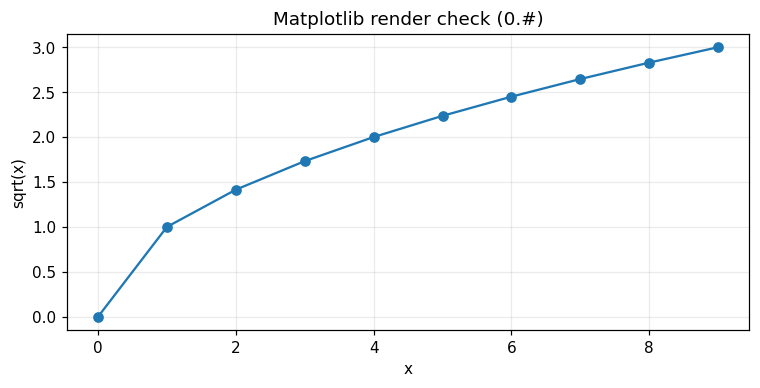

{"module": "0.foundation.viz", "ok": true, "note": "Matplotlib rendering OK", "extra": {}}


/tmp/ipython-input-167704889.py:9: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "ts": datetime.datetime.utcnow().isoformat() + "Z",


In [24]:
# cell 0.7: foundations: visualization smoke test (matplotlib only) — use plt from 0.2
try:
    xs = np.arange(0, 10); ys = np.sqrt(xs)
    plt.figure(); plt.plot(xs, ys, marker="o")
    plt.title("Matplotlib render check (0.#)"); plt.xlabel("x"); plt.ylabel("sqrt(x)")
    fig = plt.gcf(); axes = fig.get_axes()
    assert axes and any(ax.has_data() for ax in axes), "No plotted data detected"
    plt.show()
    report_status("0.foundation.viz", True, "Matplotlib rendering OK")
except Exception as e:
    report_status("0.foundation.viz", False, f"Matplotlib failed: {e}")


In [25]:
# cell 1.0A: set SOURCE_DIR to your article folder (expects 01-*.md .. 04-*.md)
from pathlib import Path
SOURCE_DIR = Path("/content")  # adjust if needed
print({"cell_id": "cell 1.0A: set SOURCE_DIR",
       "SOURCE_DIR": str(SOURCE_DIR),
       "exists": SOURCE_DIR.exists(),
       "is_dir": SOURCE_DIR.is_dir()})

{'cell_id': 'cell 1.0A: set SOURCE_DIR', 'SOURCE_DIR': '/content', 'exists': True, 'is_dir': True}


In [26]:
# cell 1.0B: filename sanity (previews matches and version coverage by slug)
import re, json
from pathlib import Path

FNAME_RE = re.compile(r"^(?P<prefix>0[1-4])-(?P<slug>.+)\.md$")
if not SOURCE_DIR.exists() or not SOURCE_DIR.is_dir():
    raise ValueError(f"SOURCE_DIR not found or not a directory: {SOURCE_DIR}")

files = [p for p in SOURCE_DIR.iterdir() if p.is_file() and FNAME_RE.match(p.name)]
preview = [p.name for p in files[:10]]
groups = {}
for p in files:
    m = FNAME_RE.match(p.name)
    slug = m.group("slug")
    vid = int(m.group("prefix"))
    groups.setdefault(slug, []).append(vid)

summary = {slug: sorted(vs) for slug, vs in groups.items()}
print(json.dumps({
    "cell_id": "cell 1.0B: filename sanity",
    "SOURCE_DIR": str(SOURCE_DIR),
    "matches": len(files),
    "preview": preview,
    "articles": len(summary),
    "versions_by_article": summary
}, indent=2))


{
  "cell_id": "cell 1.0B: filename sanity",
  "SOURCE_DIR": "/content",
  "matches": 4,
  "preview": [
    "01-the-count-that-coudnt.md",
    "03-the-count-that-coudnt.md",
    "02-the-count-that-coudnt.md",
    "04-the-count-that-coudnt.md"
  ],
  "articles": 1,
  "versions_by_article": {
    "the-count-that-coudnt": [
      1,
      2,
      3,
      4
    ]
  }
}


In [27]:
# cell 1.1: textstat|wordfreq: install (module-only; no base upgrades; pinned, wheels-only, no-deps)
%pip install -q --only-binary=:all: --no-deps \
  "textstat>=0.7,<0.8" \
  "wordfreq>=3,<4" \
  "regex>=2023.10,<2026.0" \
  "pyarrow>=14,<18"

from pathlib import Path, PurePosixPath
import json

BASE_OUT = Path("outputs/textstat_lex")
PLOTS_OUT = BASE_OUT / "plots"
BASE_OUT.mkdir(parents=True, exist_ok=True)
PLOTS_OUT.mkdir(parents=True, exist_ok=True)

print(json.dumps({
    "cell_id": "cell 1.1: textstat|wordfreq: install",
    "status": "pass",
    "dirs": {"base": str(PurePosixPath(BASE_OUT)), "plots": str(PurePosixPath(PLOTS_OUT))}
}, indent=2))


{
  "cell_id": "cell 1.1: textstat|wordfreq: install",
  "status": "pass",
  "dirs": {
    "base": "outputs/textstat_lex",
    "plots": "outputs/textstat_lex/plots"
  }
}


In [28]:
# cell 1.2: textstat|wordfreq: imports & sanity checks + filename-driven versioning
import json, datetime, math, random, re
from pathlib import Path

import textstat
from importlib.metadata import version as _pkg_version

# Assert foundations (avoid base re-imports here)
_missing = [name for name in ("np","pd","plt") if name not in globals()]
if _missing:
    raise RuntimeError(f"Foundations not loaded (missing {_missing}). Run cell 0.2 before Module 1.")

# ---- Versions & determinism ----
VERS = {"textstat": _pkg_version("textstat"), "wordfreq": _pkg_version("wordfreq")}
np.random.seed(7); random.seed(7)

# ---- Inputs handshake ----
g = globals()
DOCS = g.get("DOCS"); TEXT = g.get("TEXT")

# If neither DOCS nor TEXT is provided, load from SOURCE_DIR using strict filename rule.
SOURCE_DIR = Path(g.get("SOURCE_DIR", "content"))

FNAME_RE = re.compile(r"^(?P<prefix>0[1-4])-(?P<slug>.+)\.md$")
NOTES = []

def _clean_markdown(s: str) -> str:
    """Regex-only light cleaner for readability/lexical metrics."""
    if not s: return ""
    s = re.sub(r"```[\s\S]*?```", " ", s)                            # fenced code blocks
    s = re.sub(r"!\[([^\]]*)\]\([^)]+\)", r"\1", s)                  # images -> alt
    s = re.sub(r"\[([^\]]+)\]\([^)]+\)", r"\1", s)                   # links -> text
    s = re.sub(r"`([^`]+)`", r"\1", s)                               # inline code
    s = re.sub(r"^\s*#{1,6}\s+", "", s, flags=re.MULTILINE)          # headings
    s = re.sub(r"[ \t]+", " ", s)                                    # spaces
    s = re.sub(r"\s*\n\s*", "\n", s).strip()                         # newlines
    return s

if DOCS is None and TEXT is not None:
    DOCS = [{"doc_id": "doc_0001", "text": TEXT, "article_id": "doc_0001", "version_id": 1,
             "version_tag": "v1", "filename": "<in-memory>", "path": "<in-memory>"}]
elif DOCS is None and TEXT is None:
    # Filename-driven discovery
    if not SOURCE_DIR.exists() or not SOURCE_DIR.is_dir():
        raise ValueError(f"Module 1: SOURCE_DIR does not exist or is not a directory: {SOURCE_DIR}")
    files = [p for p in SOURCE_DIR.iterdir() if p.is_file() and FNAME_RE.match(p.name)]
    if not files:
        raise ValueError("Module 1: No files found matching ^(0[1-4])-(.+)\\.md$ in SOURCE_DIR.")
    groups = {}
    for p in files:
        m = FNAME_RE.match(p.name)
        prefix, slug = m.group("prefix"), m.group("slug")
        vid = int(prefix)
        grp = groups.setdefault(slug, {})
        if vid in grp:
            raise ValueError(f"Duplicate version prefix for article '{slug}': {prefix}")
        grp[vid] = p
    DOCS = []
    for slug, versions in sorted(groups.items()):
        present = sorted(versions.keys())
        if len(present) < 4:
            NOTES.append(f"Article '{slug}' missing versions: {sorted(set(range(1,5)) - set(present))}")
        for vid in present:
            path = versions[vid]
            text_raw = path.read_text(encoding="utf-8-sig", errors="replace")
            text_clean = _clean_markdown(text_raw)
            DOCS.append({
                "article_id": slug,
                "version_id": vid,
                "version_tag": f"v{vid}",
                "filename": path.name,
                "path": str(path),
                "doc_id": f"{slug}::v{vid}",
                "text_raw": text_raw,
                "text": text_clean,   # downstream cells use 'text'
            })
else:
    # DOCS provided by user: validate shape
    if not (isinstance(DOCS, list) and all(isinstance(d, dict) for d in DOCS)):
        raise ValueError("DOCS must be a list of dicts.")
    if not all(("doc_id" in d and "text" in d) for d in DOCS):
        raise ValueError("DOCS dicts must include 'doc_id' and 'text'.")

# ---- Metadata ----
BASE_OUT = Path("outputs/textstat_lex"); PLOTS_OUT = BASE_OUT / "plots"
BASE_OUT.mkdir(parents=True, exist_ok=True); PLOTS_OUT.mkdir(parents=True, exist_ok=True)
metadata_path = BASE_OUT / "metadata.json"

articles = {}
for d in DOCS:
    slug = d.get("article_id", d.get("doc_id", "<doc>"))
    vid = d.get("version_id")
    if slug not in articles: articles[slug] = []
    if vid is not None and vid not in articles[slug]:
        articles[slug].append(vid)
for slug in articles:
    articles[slug] = sorted(articles[slug])

metadata = {
    "module": "module_1_textstat_lex_v1",
    "timestamp_utc": datetime.datetime.utcnow().isoformat(timespec="seconds") + "Z",
    "seed": 7,
    "library_versions": VERS,
    "input_count": len(DOCS),
    "source_dir": (
        str(SOURCE_DIR.resolve())
        if (TEXT is None and isinstance(DOCS, list) and len(DOCS) and isinstance(DOCS[0], dict) and "path" in DOCS[0])
        else None
    ),
    "articles": len(articles) if articles else None,
    "versions_per_article_min": min((len(v) for v in articles.values()), default=None),
    "versions_per_article_max": max((len(v) for v in articles.values()), default=None),
    "expected_versions": 4,
    "version_order_source": "filename_prefix",
    "notes": NOTES,
}
metadata_path.write_text(json.dumps(metadata, indent=2), encoding="utf-8")

print(json.dumps({
    "cell_id": "cell 1.2: textstat|wordfreq: imports & sanity checks",
    "status": "pass",
    "inputs": len(DOCS),
    "articles": len(articles) if articles else 1,
    "metadata": str(metadata_path),
    "versions": VERS
}, indent=2))


{
  "cell_id": "cell 1.2: textstat|wordfreq: imports & sanity checks",
  "status": "pass",
  "inputs": 4,
  "articles": 1,
  "metadata": "outputs/textstat_lex/metadata.json",
  "versions": {
    "textstat": "0.7.10",
    "wordfreq": "3.1.1"
  }
}


/tmp/ipython-input-731714914.py:101: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "timestamp_utc": datetime.datetime.utcnow().isoformat(timespec="seconds") + "Z",


In [29]:
# cell 1.3: textstat: readability metrics (document-level on text_clean)
problems = []
rows = []

# naive sentence split for eligibility check (not for final stats)
SENT_SPLIT = re.compile(r'(?<=[.!?])\s+')

def _eligible(text: str) -> bool:
    if text is None: return False
    if len(text) < 200: return False
    sents = [s for s in SENT_SPLIT.split(text.strip()) if s]
    return len(sents) >= 3

for d in DOCS:
    doc_id = str(d.get("doc_id", d.get("article_id", "doc")) )
    text = d.get("text") or ""
    row = {
        "doc_id": doc_id,
        "article_id": d.get("article_id", None),
        "version_id": d.get("version_id", None),
        "version_tag": d.get("version_tag", None),
        "filename": d.get("filename", None),
        "path": d.get("path", None),
        "n_chars": int(len(text)),
    }
    heavy_ok = _eligible(text)

    metrics = {
        "flesch_reading_ease": textstat.flesch_reading_ease,
        "flesch_kincaid_grade": textstat.flesch_kincaid_grade,
        "gunning_fog": textstat.gunning_fog,
        "smog_index": textstat.smog_index,
        "coleman_liau_index": textstat.coleman_liau_index,
        "automated_readability_index": textstat.automated_readability_index,
        "dale_chall_readability_score": textstat.dale_chall_readability_score,
        "linsear_write_formula": textstat.linsear_write_formula,
    }

    if heavy_ok:
        for k, fn in metrics.items():
            try:
                row[k] = float(fn(text))
            except Exception as e:
                row[k] = np.nan
                problems.append({"doc_id": doc_id, "metric": k, "error": str(e)})
        try:
            row["text_standard"] = str(textstat.text_standard(text))
        except Exception as e:
            row["text_standard"] = ""
            problems.append({"doc_id": doc_id, "metric": "text_standard", "error": str(e)})
    else:
        for k in metrics.keys(): row[k] = np.nan
        row["text_standard"] = ""

    rows.append(row)

df_lex = pd.DataFrame(rows)

print(json.dumps({
    "cell_id": "cell 1.3: textstat: readability metrics",
    "status": "pass", "docs": int(len(df_lex)), "problems": int(len(problems))
}, indent=2))


{
  "cell_id": "cell 1.3: textstat: readability metrics",
  "status": "pass",
  "docs": 4,
  "problems": 0
}


In [30]:
# cell 1.4: wordfreq: Zipf frequency features (Unicode-aware, regex-only tokenization)
import regex as rxx
from wordfreq import zipf_frequency

TOKEN_RE = rxx.compile(r"\b[\p{L}\p{M}\p{N}’'-]+\b", flags=rxx.UNICODE)

def tokenize(text: str):
    return [m.group(0) for m in TOKEN_RE.finditer(text or "")]

def token_zipf_stats(tokens):
    lowers = [t.lower() for t in tokens]
    freqs = [zipf_frequency(t, 'en', wordlist='best') for t in lowers]
    freqs = [f for f in freqs if f is not None and f > 0]
    if len(freqs) == 0:
        return {
            "zipf_mean": np.nan, "zipf_std": np.nan,
            "zipf_p25": np.nan, "zipf_p50": np.nan, "zipf_p75": np.nan,
            "rare_rate": np.nan, "mid_rate": np.nan, "common_rate": np.nan
        }, []
    arr = np.asarray(freqs, dtype=float)
    stats = {
        "zipf_mean": float(np.mean(arr)),
        "zipf_std": float(np.std(arr, ddof=0)),
        "zipf_p25": float(np.percentile(arr, 25)),
        "zipf_p50": float(np.percentile(arr, 50)),
        "zipf_p75": float(np.percentile(arr, 75)),
        "rare_rate": float(np.mean(arr < 3.0)),
        "mid_rate":  float(np.mean((arr >= 3.0) & (arr < 5.0))),
        "common_rate": float(np.mean(arr >= 5.0)),
    }
    return stats, arr

def latin_alpha_ratio(text: str) -> float:
    if not text: return 0.0
    all_alpha = [ch for ch in text if ch.isalpha()]
    if not all_alpha: return 0.0
    latin = [ch for ch in all_alpha if ('A' <= ch <= 'Z') or ('a' <= ch <= 'z')]
    return len(latin) / len(all_alpha)

ZIPF_ALL = []
zipf_rows = []
for idx, d in enumerate(DOCS):
    doc_id, text = str(d.get("doc_id", f"doc_{idx:04d}")), (d.get("text") or "")
    toks = tokenize(text)
    stats, freqs = token_zipf_stats(toks)
    zipf_rows.append({"doc_id": doc_id, **stats})
    if len(freqs): ZIPF_ALL.append(np.asarray(freqs, dtype=float))

df_zipf = pd.DataFrame(zipf_rows)
df_lex = df_lex.merge(df_zipf, on="doc_id", how="left")

# language heuristic update (non-blocking)
meta_path = Path("outputs/textstat_lex/metadata.json")
try:
    meta = json.loads(meta_path.read_text(encoding="utf-8"))
    ratios = [latin_alpha_ratio(d.get("text") or "") for d in DOCS]
    if len(ratios) and float(np.mean([r < 0.5 for r in ratios])) > 0.5:
        meta["lang_guess"] = "non_en_possible"
    meta_path.write_text(json.dumps(meta, indent=2), encoding="utf-8")
except Exception:
    pass

ZIPF_ALL = np.concatenate(ZIPF_ALL, axis=0) if len(ZIPF_ALL) else np.array([], dtype=float)

print(json.dumps({
    "cell_id": "cell 1.4: wordfreq: Zipf frequency features",
    "status": "pass", "docs": int(len(df_zipf)), "zipf_values": int(ZIPF_ALL.size)
}, indent=2))


{
  "cell_id": "cell 1.4: wordfreq: Zipf frequency features",
  "status": "pass",
  "docs": 4,
  "zipf_values": 5304
}


In [31]:
# cell 1.5: lexicons: function-word profile, TTR, naive sentence stats + dtype enforcement
from pathlib import Path

# Reuse TOKEN_RE & tokenize from 1.4

LEX_PATH = Path("lexicons/function_words_en.txt")
if LEX_PATH.exists():
    FUNC_WORDS = {w.strip().lower() for w in LEX_PATH.read_text(encoding="utf-8").splitlines() if w.strip()}
else:
    FUNC_WORDS = {
        "a","an","the","and","or","but","if","because","as","until","while",
        "of","at","by","for","with","about","against","between","into","through",
        "during","before","after","above","below","to","from","up","down","in","out",
        "on","off","over","under","again","further","then","once","here","there",
        "when","where","why","how","all","any","both","each","few","more","most",
        "other","some","such","no","nor","not","only","own","same","so","than","too","very",
        "can","will","just","don","should","now","i","you","he","she","it","we","they",
        "me","him","her","us","them","my","your","his","its","our","their",
        "is","am","are","was","were","be","been","being","have","has","had","do","does","did"
    }

PUNCT_CHARS = set(list(".,;:!?—–-()[]'\"“”‘’"))
SENT_SPLIT_FOR_STATS = rxx.compile(r"(?<=[.!?])\s+(?=[A-Z])")

SENT_LEN_ALL = []
rows = []
for idx, d in enumerate(DOCS):
    doc_id, text = str(d.get("doc_id", f"doc_{idx:04d}")), (d.get("text") or "")
    toks = tokenize(text)
    n_tokens = int(len(toks))
    lowers = [t.lower() for t in toks]
    n_unique = len(set(lowers))
    ttr = float(n_unique / n_tokens) if n_tokens > 0 else float("nan")
    fw_rate = float(sum(1 for t in lowers if t in FUNC_WORDS) / n_tokens) if n_tokens > 0 else float("nan")
    tok_lens = np.array([len(t) for t in toks], dtype=float) if n_tokens > 0 else np.array([], dtype=float)
    token_len_mean = float(tok_lens.mean()) if tok_lens.size else float("nan")
    token_len_std  = float(tok_lens.std(ddof=0)) if tok_lens.size else float("nan")
    pden = (sum(1 for ch in (text or "") if ch in PUNCT_CHARS) / n_tokens * 100.0) if n_tokens > 0 else float("nan")

    sents = [s for s in SENT_SPLIT_FOR_STATS.split(text.strip()) if s]
    sent_lens = [len(tokenize(s)) for s in sents] if sents else []
    if sent_lens: SENT_LEN_ALL.extend(sent_lens)
    naive_sentence_count = int(len(sents))
    naive_sentence_len_mean = float(np.mean(sent_lens)) if sent_lens else float("nan")
    naive_sentence_len_std  = float(np.std(sent_lens, ddof=0)) if sent_lens else float("nan")

    rows.append({
        "doc_id": doc_id,
        "n_tokens_regex": n_tokens,
        "ttr": ttr,
        "function_word_rate": fw_rate,
        "punctuation_density_per_100toks": pden,
        "token_len_mean": token_len_mean,
        "token_len_std": token_len_std,
        "naive_sentence_count": naive_sentence_count,
        "naive_sentence_len_mean": naive_sentence_len_mean,
        "naive_sentence_len_std": naive_sentence_len_std,
    })

df_lex2 = pd.DataFrame(rows)
df_lex = df_lex.merge(df_lex2, on="doc_id", how="left")

# ---- dtype & required columns (includes filename-driven identifiers) ----
required_cols = [
    "doc_id","article_id","version_id","version_tag","filename","path",
    "n_chars","n_tokens_regex","ttr","function_word_rate","punctuation_density_per_100toks",
    "token_len_mean","token_len_std","zipf_mean","zipf_std","zipf_p25","zipf_p50","zipf_p75",
    "rare_rate","mid_rate","common_rate","flesch_reading_ease","flesch_kincaid_grade","gunning_fog",
    "smog_index","coleman_liau_index","automated_readability_index","dale_chall_readability_score",
    "linsear_write_formula","text_standard","naive_sentence_count","naive_sentence_len_mean",
    "naive_sentence_len_std"
]
for c in required_cols:
    if c not in df_lex.columns:
        df_lex[c] = np.nan

# identifiers
df_lex["doc_id"] = df_lex["doc_id"].astype("string")
df_lex["article_id"] = df_lex["article_id"].astype("string")
df_lex["version_tag"] = df_lex["version_tag"].astype("string")
df_lex["filename"] = df_lex["filename"].astype("string")
df_lex["path"] = df_lex["path"].astype("string")
df_lex["version_id"] = pd.to_numeric(df_lex["version_id"], errors="coerce").fillna(0).astype("int64")

# ints
for c in ["n_chars","n_tokens_regex","naive_sentence_count"]:
    df_lex[c] = pd.to_numeric(df_lex[c], errors="coerce").fillna(0).astype("int64")

# strings
df_lex["text_standard"] = df_lex["text_standard"].astype("string")

# floats
float_cols = [c for c in required_cols if c not in
              ["doc_id","article_id","version_id","version_tag","filename","path",
               "n_chars","n_tokens_regex","naive_sentence_count","text_standard"]]
for c in float_cols:
    df_lex[c] = pd.to_numeric(df_lex[c], errors="coerce").astype("float64")

print(json.dumps({
    "cell_id": "cell 1.5: lexicons: function-word profile & TTR",
    "status": "pass", "docs": int(len(df_lex)), "have_sent_len": int(len(SENT_LEN_ALL))
}, indent=2))


{
  "cell_id": "cell 1.5: lexicons: function-word profile & TTR",
  "status": "pass",
  "docs": 4,
  "have_sent_len": 277
}


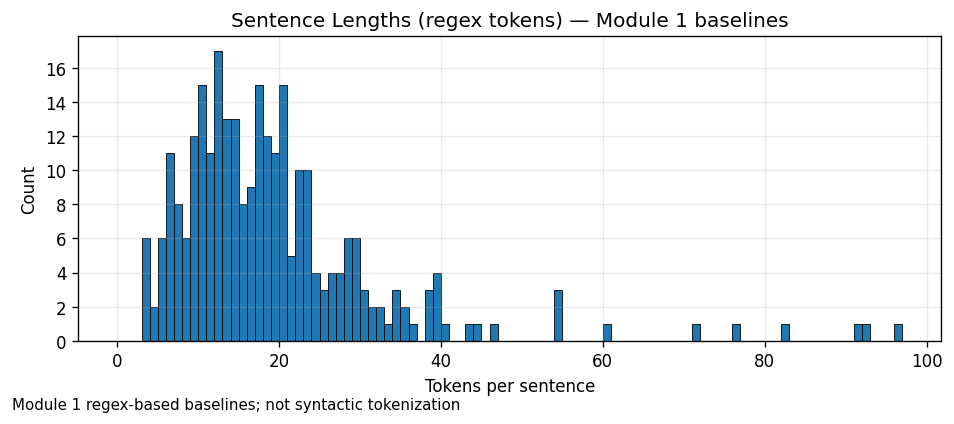

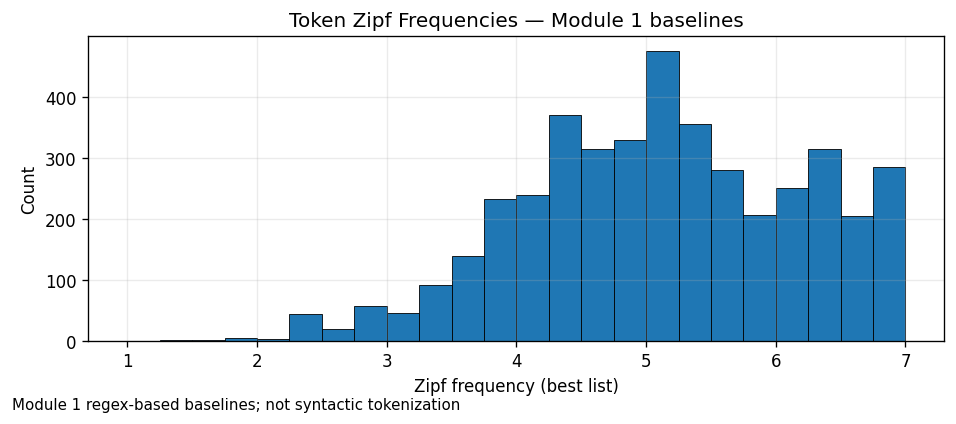

{
  "cell_id": "cell 1.6: textstat|wordfreq: visuals \u2014 baseline distributions (+per-article & deltas)",
  "status": "pass",
  "plots": {
    "sentence_length_hist": true,
    "zipf_hist": true,
    "per_article": true
  },
  "artifacts": {
    "features_parquet": "outputs/textstat_lex/lexical_features.parquet",
    "deltas_parquet": "outputs/textstat_lex/lexical_deltas.parquet"
  }
}


In [32]:
# cell 1.6: textstat|wordfreq: visuals — baseline distributions + per-article trends + deltas
from pathlib import Path
import json

BASE_OUT = Path("outputs/textstat_lex"); PLOTS_OUT = BASE_OUT / "plots"
PLOTS_OUT.mkdir(parents=True, exist_ok=True)

# Assert foundations / prior cells present (no base re-imports here)
_missing = [name for name in ("np","pd","plt","df_lex") if name not in globals()]
if _missing:
    raise RuntimeError(f"Prereqs missing in cell 1.6: {_missing}. Run 0.2 and cells 1.3–1.5 first.")

# Fallback tokenizer if 1.4 wasn't run
try:
    TOKEN_RE  # noqa: F821
except NameError:
    import regex as rxx
    TOKEN_RE = rxx.compile(r"\b[\p{L}\p{M}\p{N}’'-]+\b", flags=rxx.UNICODE)

def _placeholder_plot(title, note, outfile):
    plt.figure(dpi=120)
    plt.text(0.5, 0.6, "No data available", ha="center", va="center", fontsize=12)
    plt.text(0.5, 0.4, note, ha="center", va="center", fontsize=9)
    plt.title(title); plt.axis("off")
    plt.tight_layout(); plt.savefig(outfile); plt.show(); plt.close()

# ---- Global histograms ----
# Sentence length histogram
try:
    sent_ok = False
    if 'SENT_LEN_ALL' in globals() and len(SENT_LEN_ALL):
        plt.figure(dpi=120)
        bins = np.arange(0, max(SENT_LEN_ALL)+2)
        plt.hist(SENT_LEN_ALL, bins=bins, edgecolor='black', linewidth=0.5)
        plt.title("Sentence Lengths (regex tokens) — Module 1 baselines")
        plt.xlabel("Tokens per sentence"); plt.ylabel("Count")
        plt.figtext(0.01, 0.01, "Module 1 regex-based baselines; not syntactic tokenization",
                    ha="left", fontsize=9)
        out1 = PLOTS_OUT / "sentence_length_hist.png"
        plt.tight_layout(); plt.savefig(out1); plt.show()
        sent_ok = True
    else:
        out1 = PLOTS_OUT / "sentence_length_hist.png"
        _placeholder_plot("Sentence Lengths — Module 1 baselines",
                          "Regex tokens; produced as placeholder due to empty input.",
                          out1)
except Exception as e:
    print(json.dumps({"plot": "sentence_length_hist", "error": str(e)}))

# Zipf frequency histogram
try:
    zipf_ok = False
    if 'ZIPF_ALL' in globals() and getattr(ZIPF_ALL, "size", 0):
        plt.figure(dpi=120)
        bins = np.arange(1.0, 7.01, 0.25)
        plt.hist(ZIPF_ALL, bins=bins, edgecolor='black', linewidth=0.5)
        plt.title("Token Zipf Frequencies — Module 1 baselines")
        plt.xlabel("Zipf frequency (best list)"); plt.ylabel("Count")
        plt.figtext(0.01, 0.01, "Module 1 regex-based baselines; not syntactic tokenization",
                    ha="left", fontsize=9)
        out2 = PLOTS_OUT / "zipf_hist.png"
        plt.tight_layout(); plt.savefig(out2); plt.show()
        zipf_ok = True
    else:
        out2 = PLOTS_OUT / "zipf_hist.png"
        _placeholder_plot("Token Zipf Frequencies — Module 1 baselines",
                          "English word list; produced as placeholder due to empty input.",
                          out2)
except Exception as e:
    print(json.dumps({"plot": "zipf_hist", "error": str(e)}))

# ---- Per-article visuals (up to first 10 slugs alphabetically) ----
per_article_ok = True
try:
    if "article_id" in df_lex.columns and df_lex["article_id"].notna().any():
        for slug in sorted(df_lex["article_id"].dropna().unique())[:10]:
            sub = df_lex[df_lex["article_id"] == slug].copy()
            if "version_id" in sub.columns:
                sub = sub.sort_values("version_id")
            # Trend: Flesch Reading Ease across versions
            try:
                plt.figure(dpi=120)
                plt.plot(sub["version_id"], sub["flesch_reading_ease"], marker="o")
                plt.title(f"Flesch Reading Ease — {slug} (v1..v4)")
                plt.xlabel("Version (from filename prefix)"); plt.ylabel("Flesch Reading Ease")
                plt.xticks(sub["version_id"])
                outp = PLOTS_OUT / f"trend_flesch_reading_ease_{slug}.png"
                plt.tight_layout(); plt.savefig(outp); plt.close()
            except Exception as e:
                per_article_ok = False
                print(json.dumps({"plot": "trend_flesch", "slug": slug, "error": str(e)}))
            # Stacked bars: Zipf bins per version
            try:
                plt.figure(dpi=120)
                idx = sub["version_id"].astype(int).to_numpy()
                rare = sub["rare_rate"].fillna(0).to_numpy()
                mid  = sub["mid_rate"].fillna(0).to_numpy()
                com  = sub["common_rate"].fillna(0).to_numpy()
                plt.bar(idx, rare, label="rare <3.0")
                plt.bar(idx, mid, bottom=rare, label="mid 3–<5")
                plt.bar(idx, com, bottom=rare+mid, label="common ≥5")
                plt.title(f"Zipf Bins — {slug} (v1..v4)")
                plt.xlabel("Version (from filename prefix)"); plt.ylabel("Fraction")
                plt.xticks(idx); plt.ylim(0, 1); plt.legend(frameon=False)
                outp = PLOTS_OUT / f"zipf_bins_stacked_{slug}.png"
                plt.tight_layout(); plt.savefig(outp); plt.close()
            except Exception as e:
                per_article_ok = False
                print(json.dumps({"plot": "zipf_bins_stacked", "slug": slug, "error": str(e)}))
except Exception as e:
    per_article_ok = False
    print(json.dumps({"plot": "per_article", "error": str(e)}))

# ---- Write Parquet artifact (document-level) ----
parquet_path = BASE_OUT / "lexical_features.parquet"
df_lex.to_parquet(parquet_path, index=False, engine="pyarrow")

# ---- Deltas between consecutive versions within each article ----
def _token_set(text: str) -> set:
    return set([m.group(0).lower() for m in TOKEN_RE.finditer(text or "")])

def token_jaccard(a_text: str, b_text: str) -> float:
    A, B = _token_set(a_text), _token_set(b_text)
    if not A and not B: return float("nan")
    inter = len(A & B); uni = len(A | B)
    return inter / uni if uni else float("nan")

def js_divergence(p, q, eps=1e-8):
    p = np.asarray(p, dtype=float) + eps
    q = np.asarray(q, dtype=float) + eps
    p /= p.sum(); q /= q.sum()
    m = 0.5 * (p + q)
    kl = lambda x, y: np.sum(x * np.log(x / y))
    return float(0.5 * kl(p, m) + 0.5 * kl(q, m))

delta_rows = []
if "article_id" in df_lex.columns and df_lex["article_id"].notna().any():
    # need access to original cleaned text for jaccard; rebuild map from DOCS
    text_map = {d.get("doc_id", f"doc_{i:04d}"): d.get("text","") for i,d in enumerate(DOCS)}
    for slug in sorted(df_lex["article_id"].dropna().unique()):
        sub = df_lex[df_lex["article_id"] == slug].copy().sort_values("version_id")
        vids = sub["version_id"].astype(int).tolist()
        docs_order = sub["doc_id"].tolist()
        for i in range(len(vids)-1):
            v_from, v_to = vids[i], vids[i+1]
            if v_to != v_from + 1:  # only adjacent pairs (1->2, 2->3, 3->4)
                continue
            docA, docB = docs_order[i], docs_order[i+1]
            p = [float(sub.iloc[i]["rare_rate"] or 0), float(sub.iloc[i]["mid_rate"] or 0), float(sub.iloc[i]["common_rate"] or 0)]
            q = [float(sub.iloc[i+1]["rare_rate"] or 0), float(sub.iloc[i+1]["mid_rate"] or 0), float(sub.iloc[i+1]["common_rate"] or 0)]
            delta_rows.append({
                "article_id": slug,
                "from_version": int(v_from),
                "to_version": int(v_to),
                "token_jaccard": token_jaccard(text_map.get(docA,""), text_map.get(docB,"")),
                "zipf_jsd": js_divergence(p, q),
            })

df_deltas = pd.DataFrame(delta_rows) if delta_rows else pd.DataFrame(
    columns=["article_id","from_version","to_version","token_jaccard","zipf_jsd"])
deltas_path = BASE_OUT / "lexical_deltas.parquet"
df_deltas.to_parquet(deltas_path, index=False, engine="pyarrow")

print(json.dumps({
    "cell_id": "cell 1.6: textstat|wordfreq: visuals — baseline distributions (+per-article & deltas)",
    "status": "pass",
    "plots": {"sentence_length_hist": bool('sent_ok' in locals() and sent_ok),
              "zipf_hist": bool('zipf_ok' in locals() and zipf_ok),
              "per_article": bool(per_article_ok)},
    "artifacts": {"features_parquet": str(parquet_path), "deltas_parquet": str(deltas_path)}
}, indent=2))


In [34]:
# cell 1.Y: Module 1 validtion
import pandas as pd, json, pathlib

base = pathlib.Path("outputs/textstat_lex")  # or the folder where you placed them
meta = json.loads((base / "metadata.json").read_text())
feat = pd.read_parquet(base / "lexical_features.parquet")
delt = pd.read_parquet(base / "lexical_deltas.parquet")

print("version_order_source:", meta.get("version_order_source"))

# Features: required keys
req_feat = {"article_id","version_id","version_tag","doc_id"}
print("features missing keys:", sorted(req_feat - set(feat.columns)))

# Deltas: adjacency & ranges
req_delta = {"article_id","from_version","to_version","token_jaccard","zipf_jsd"}
print("deltas missing keys:", sorted(req_delta - set(delt.columns)))
print("adjacent only:", ((delt["to_version"] - delt["from_version"]) == 1).all())
print("token_jaccard in [0,1]:", delt["token_jaccard"].dropna().between(0,1).all())
print("zipf_jsd in [0,1]:", delt["zipf_jsd"].dropna().between(0,1).all())


version_order_source: filename_prefix
features missing keys: []
deltas missing keys: []
adjacent only: True
token_jaccard in [0,1]: True
zipf_jsd in [0,1]: True


In [33]:
# cell 1.Z: package Module 1 outputs into a zip archive
import shutil, json
from pathlib import Path

OUT_DIR = Path("outputs/textstat_lex")
ZIP_PATH = Path("outputs/textstat_lex_outputs.zip")

if OUT_DIR.exists():
    if ZIP_PATH.exists():
        ZIP_PATH.unlink()  # remove old zip if present
    shutil.make_archive(str(ZIP_PATH.with_suffix("")), "zip", OUT_DIR)
    print(json.dumps({
        "cell_id": "cell 1.Z: zip outputs",
        "status": "pass",
        "zipped": str(ZIP_PATH),
        "size_bytes": ZIP_PATH.stat().st_size
    }, indent=2))
else:
    print(json.dumps({
        "cell_id": "cell 1.Z: zip outputs",
        "status": "fail",
        "error": f"Output directory not found: {OUT_DIR}"
    }, indent=2))


{
  "cell_id": "cell 1.Z: zip outputs",
  "status": "pass",
  "zipped": "outputs/textstat_lex_outputs.zip",
  "size_bytes": 126249
}
